In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/mit_bih/

/content/drive/MyDrive/mit_bih


In [3]:
!ls -l

total 4
drwx------ 2 root root 4096 Nov  6 06:00 mit-bih-arrhythmia-database-1.0.0


In [4]:
!pip install wfdb

In [6]:
!ls -l

total 4
drwx------ 2 root root 4096 Nov  6 06:00 mit-bih-arrhythmia-database-1.0.0


In [7]:
import wfdb

In [23]:
record_name = 'mit-bih-arrhythmia-database-1.0.0/100'

In [24]:
record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'atr')
print(record.sig_name)
print(record.fs )
print( record.sig_len)
print(record.p_signal.shape)
print(record.p_signal[:5])
print(annotation.symbol[:10])
print(annotation.sample[:10])

['MLII', 'V5']
360
650000
(650000, 2)
[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']
[  18   77  370  662  946 1231 1515 1809 2044 2402]


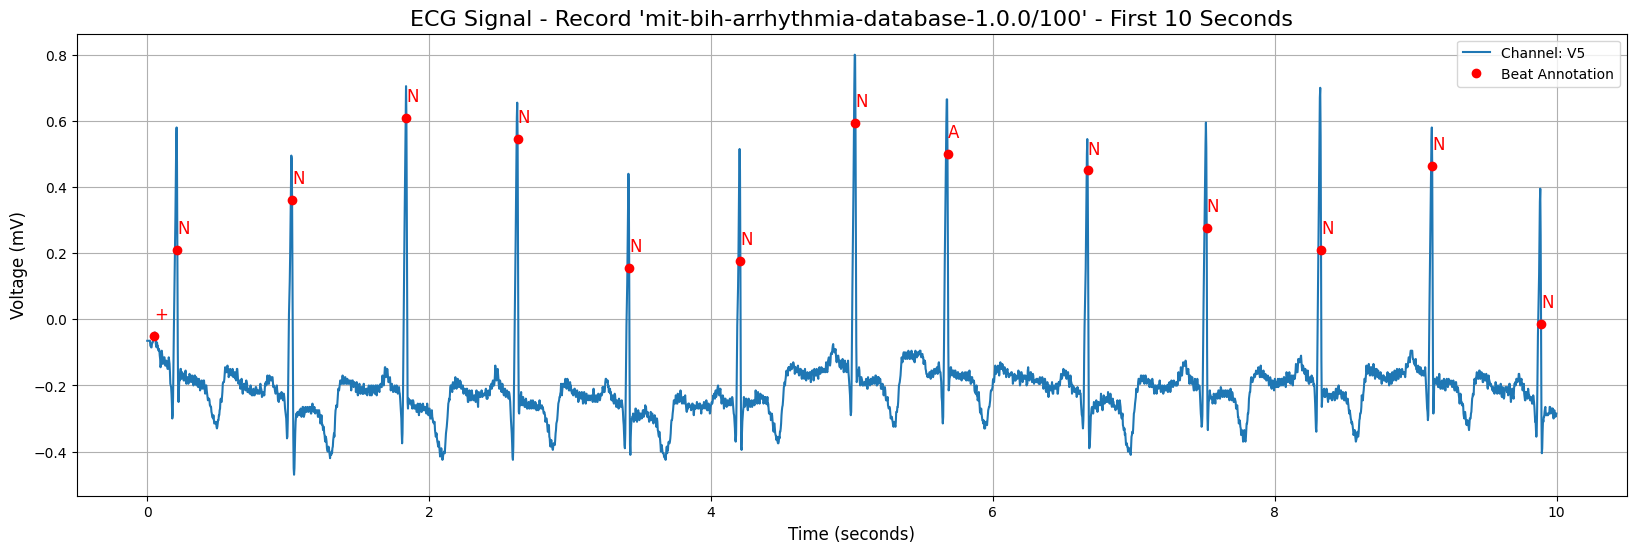

In [26]:
import matplotlib.pyplot as plt
import numpy as np

seconds_to_plot = 10
channel_to_plot = 1

fs = record.fs

num_samples = seconds_to_plot * fs

signal = record.p_signal[:num_samples, channel_to_plot]

time_axis = np.arange(num_samples) / fs

ann_indices_in_range = np.where(annotation.sample < num_samples)[0]
ann_samples_in_range = annotation.sample[ann_indices_in_range]
ann_symbols_in_range = np.array(annotation.symbol)[ann_indices_in_range]

ann_y_values = signal[ann_samples_in_range]

plt.figure(figsize=(20, 6))

plt.plot(time_axis, signal, label=f'Channel: {record.sig_name[channel_to_plot]}')

plt.plot(ann_samples_in_range / fs, ann_y_values, 'ro', label='Beat Annotation')

for i, symbol in enumerate(ann_symbols_in_range):
    plt.text(ann_samples_in_range[i] / fs, ann_y_values[i] + 0.05, symbol, fontsize=12, color='red')

plt.title(f"ECG Signal - Record '{record_name}' - First {seconds_to_plot} Seconds", fontsize=16)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Voltage (mV)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import numpy as np

ecg_signals=record.p_signal

type(ecg_signals)

numpy.ndarray

In [34]:
print(ecg_signals[5:])

[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]


In [35]:
!pip install scikit-learn

In [36]:
from sklearn.preprocessing import StandardScaler

raw_signals = record.p_signal
print(type(raw_signals))
print(f"Original shape (samples, channels): {raw_signals.shape}")

<class 'numpy.ndarray'>
Original shape (samples, channels): (650000, 2)


In [37]:
raw_signals = record.p_signal

mlii_raw = raw_signals[:, 0]
v5_raw = raw_signals[:, 1]

summed_signal_raw = mlii_raw + v5_raw

print( mlii_raw.shape)
print(summed_signal_raw.shape)

print(f"  Original Mean: {np.mean(summed_signal_raw)}")
print(f"  Original Std Dev: {np.std(summed_signal_raw)}")

summed_signal_reshaped = summed_signal_raw.reshape(-1, 1)

scaler_summed = StandardScaler()
scaled_summed_signal = scaler_summed.fit_transform(summed_signal_reshaped)

print(f"\n--- 'AFTER' Scaling Summed Signal ---")
print(f"  Scaled Mean: {np.mean(scaled_summed_signal)}")
print(f"  Scaled Std Dev: {np.std(scaled_summed_signal)}")

print(scaled_summed_signal[:5])

(650000,)
(650000,)
  Original Mean: -0.4973334076923078
  Original Std Dev: 0.3062989011772449

--- 'AFTER' Scaling Summed Signal ---
  Scaled Mean: 4.561465735045764e-16
  Scaled Std Dev: 0.9999999999999998
[[0.93808174]
 [0.93808174]
 [0.93808174]
 [0.93808174]
 [0.93808174]]


In [39]:
import wfdb.processing

fs = record.fs

xqrs = wfdb.processing.XQRS(sig=summed_signal_raw, fs=fs)
xqrs.detect()

detected_peaks = xqrs.qrs_inds
print("\n--- XQRS Detection (Experiment) ---")
print(annotation.sample[:10])

print(detected_peaks[:10])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.

--- XQRS Detection (Experiment) ---
[  18   77  370  662  946 1231 1515 1809 2044 2402]
[  75  369  661  945 1230 1513 1808 2043 2401 2704]


In [40]:
import wfdb.processing

fs = record.fs

xqrs = wfdb.processing.XQRS(sig=mlii_raw, fs=fs)
xqrs.detect()

detected_peaks = xqrs.qrs_inds
print("\n--- XQRS Detection (Experiment) ---")
print(annotation.sample[:10])

print(detected_peaks[:10])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.

--- XQRS Detection (Experiment) ---
[  18   77  370  662  946 1231 1515 1809 2044 2402]
[  76  370  662  946 1231 1515 1809 2044 2402 2705]


In [42]:
import numpy as np
import wfdb
import wfdb.processing


print("Running XQRS peak detection...")
fs = record.fs
xqrs = wfdb.processing.XQRS(sig=summed_signal_raw, fs=fs)
xqrs.detect()

detected_peaks = xqrs.qrs_inds
print(f"Found {len(detected_peaks)} peaks using XQRS.")


final_signal = scaled_summed_signal.flatten()

true_peaks = annotation.sample
true_labels = annotation.symbol

valid_beat_labels = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

# --- Configuration ---
window_size = 180
win_half_left = window_size // 2  # 90
win_half_right = window_size // 2 # 90
tolerance = int(0.1 * fs) # 100ms tolerance (e.g., 36 samples)

heartbeats = []
labels = []

print(window_size)

for xqrs_peak in detected_peaks:

    start = xqrs_peak - win_half_left
    end = xqrs_peak + win_half_right

    if start < 0 or end >= len(final_signal):
        continue

    distances = np.abs(true_peaks - xqrs_peak)
    closest_true_index = np.argmin(distances)
    if distances[closest_true_index] <= tolerance:
        label = true_labels[closest_true_index]

        if label in valid_beat_labels:
            segment = final_signal[start:end]
            heartbeats.append(segment)
            labels.append(label)

# --- Final Conversion ---
X_data = np.array(heartbeats)
y_data = np.array(labels)

print("\n--- Preprocessing Complete ---")
print(f"Shape of X_data (beats, features): {X_data.shape}")
print(f"Shape of y_data (labels,): {y_data.shape}")
print(f"Total valid beats found and segmented: {len(y_data)}")

print(y_data[:5])

Running XQRS peak detection...
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Found 2273 peaks using XQRS.
180

--- Preprocessing Complete ---
Shape of X_data (beats, features): (2271, 180)
Shape of y_data (labels,): (2271,)
Total valid beats found and segmented: 2271
['N' 'N' 'N' 'N' 'N']


In [43]:
import numpy as np
import wfdb
import wfdb.processing
from sklearn.preprocessing import StandardScaler
import os
from glob import glob
from tqdm import tqdm # For a helpful progress bar


data_dir = 'mit-bih-arrhythmia-database-1.0.0'

header_files = glob(os.path.join(data_dir, '*.hea'))
record_names = [os.path.basename(f).replace('.hea', '') for f in header_files]
record_names = [r for r in record_names if r.isdigit()]
record_names.sort()

print(f"Found {len(record_names)} records. Starting processing...")

all_X_data = []
all_y_data = []

# --- 3. Define Parameters ---
valid_beat_labels = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']
window_size = 180
win_half_left = window_size // 2
win_half_right = window_size // 2

for record_name in tqdm(record_names):
    record_path = os.path.join(data_dir, record_name)

    try:
        # --- A: Load Data ---
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
        fs = record.fs

        # --- B: Create Summed Signal (RAW) ---
        mlii_raw = record.p_signal[:, 0]
        v5_raw = record.p_signal[:, 1]
        summed_signal_raw = mlii_raw + v5_raw

        # --- C: Scale the Summed Signal ---
        # We re-fit the scaler for each record.
        summed_signal_reshaped = summed_signal_raw.reshape(-1, 1)
        scaler_summed = StandardScaler()
        scaled_summed_signal = scaler_summed.fit_transform(summed_signal_reshaped)
        final_signal = scaled_summed_signal.flatten() # 1D scaled signal

        # --- D: Run XQRS on RAW Signal ---
        xqrs = wfdb.processing.XQRS(sig=summed_signal_raw, fs=fs)
        # Pass verbose=False to stop it from printing "Learning..." 2273 times
        xqrs.detect(verbose=False)
        detected_peaks = xqrs.qrs_inds

        true_peaks = annotation.sample
        true_labels = annotation.symbol
        tolerance = int(0.1 * fs) # 100ms tolerance

        heartbeats = []
        labels = []

        for xqrs_peak in detected_peaks:
            start = xqrs_peak - win_half_left
            end = xqrs_peak + win_half_right

            if start < 0 or end >= len(final_signal):
                continue # Skip beats too close to the edge

            # Find the closest "true" label
            distances = np.abs(true_peaks - xqrs_peak)
            closest_true_index = np.argmin(distances)

            if distances[closest_true_index] <= tolerance:
                label = true_labels[closest_true_index]
                if label in valid_beat_labels:
                    segment = final_signal[start:end]
                    heartbeats.append(segment)
                    labels.append(label)

        # --- F: Append this file's data to global lists ---
        if len(heartbeats) > 0:
            all_X_data.append(np.array(heartbeats))
            all_y_data.append(np.array(labels))

    except Exception as e:
        print(f"\nError processing record {record_name}: {e}")

print("\n Processing Complete")

X_final_dataset = np.concatenate(all_X_data, axis=0)
y_final_dataset = np.concatenate(all_y_data, axis=0)

print(f"Final X_data shape  {X_final_dataset.shape}")
print(f"Final y_data shape {y_final_dataset.shape}")

# --- You can now save these or use them directly ---
np.save('/content/drive/MyDrive/mit_bih/X_data_summed.npy', X_final_dataset)
np.save('/content/drive/MyDrive/mit_bih/y_data_summed.npy', y_final_dataset)

Found 48 records. Starting processing...


100%|██████████| 48/48 [03:46<00:00,  4.73s/it]



 Processing Complete
Final X_data shape  (108008, 180)
Final y_data shape (108008,)


In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# N: Normal ('N', 'L', 'R', 'e', 'j')
# S: Supraventricular ('A', 'a', 'J', 'S')
# V: Ventricular ('V', 'E')
# F: Fusion ('F')
# Q: Unknown ('Q', '?', '/', 'f')

label_mapping = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    'Q': 'Q', '?': 'Q', '/': 'Q', 'f': 'Q',
    'B': 'N'

}

y_labels = y_final_dataset.copy()
y_categories = pd.Series(y_labels).map(label_mapping)


print("'Table 1' (Class Counts")
initial_counts = y_categories.value_counts()
print(initial_counts)
print(f"\nTotal beats (before dropping): {len(y_categories)}")
print(f"Beats not mapped (NaN): {y_categories.isna().sum()}")


# We create a filter 'mask' to select only the data we want
mask = y_categories.isin(['N', 'S', 'V', 'F'])

# Applying the mask to BOTH X and y
X_filtered = X_final_dataset[mask]
y_filtered = y_categories[mask]

print(f"Total heartbeats for training: {len(y_filtered)}")



print("\nSplitting ...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_filtered,
    y_filtered,
    test_size=0.25,
    stratify=y_filtered,
    random_state=42
)

print("Splitting Train/Val ")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.20,
    stratify=y_train_val,
    random_state=42
)

print("\n Final Data Shapes ---")
print(f" {X_train.shape}, {y_train.shape}")
print(f" {X_val.shape}, {y_val.shape}")
print(f"   {X_test.shape}, {y_test.shape}")


print(y_train.value_counts())


classes = np.unique(y_train)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# Create a dictionary for easy use (e.g., in Keras)
class_weight_dict = dict(zip(classes, weights))

print(f"Classes: {classes}")
print(f"Weights: {weights}")
print(class_weight_dict)

'Table 1' (Class Counts
N    90283
Q     8024
V     6222
S     2701
F      778
Name: count, dtype: int64

Total beats (before dropping): 108008
Beats not mapped (NaN): 0
Total heartbeats for training: 99984

Splitting ...
Splitting Train/Val 

 Final Data Shapes ---
 (59990, 180), (59990,)
 (14998, 180), (14998,)
   (24996, 180), (24996,)
N    54169
V     3734
S     1621
F      466
Name: count, dtype: int64
Classes: ['F' 'N' 'S' 'V']
Weights: [32.18347639  0.276865    9.25200494  4.01647027]
{'F': np.float64(32.183476394849784), 'N': np.float64(0.2768649965847625), 'S': np.float64(9.25200493522517), 'V': np.float64(4.016470273165506)}


In [46]:
import numpy as np
import os

save_dir = '/content/drive/MyDrive/mit_bih/'

os.makedirs(save_dir, exist_ok=True)

print(f"Saving files to: {save_dir}\n")

try:
    # Save Training data
    np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
    print("Saved X_train.npy and y_train.npy")

    # Save Validation data
    np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
    print("Saved X_val.npy and y_val.npy")

    # Save Testing data
    np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(save_dir, 'y_test.npy'), y_test)
    print("Saved X_test.npy and y_test.npy")

    print("\n saved successfully.")

except Exception as e:
    print(f"error  {e}")

Saving files to: /content/drive/MyDrive/mit_bih/

Saved X_train.npy and y_train.npy
Saved X_val.npy and y_val.npy
Saved X_test.npy and y_test.npy

 saved successfully.


In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dropout, BatchNormalization,
    Flatten, Dense
)

from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


label_encoder = LabelEncoder()

y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

print(f"Original labels: {y_train[:5]}")
print(f"Encoded labels: {y_train_int[:5]}")
print(f"Classes: {label_encoder.classes_}")



class_weight_dict_int = {}
for i, cls in enumerate(label_encoder.classes_):
    class_weight_dict_int[i] = class_weight_dict[cls]

print(class_weight_dict_int)



X_train_cnn = np.expand_dims(X_train, axis=-1)
X_val_cnn = np.expand_dims(X_val, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

print(f"Old X_train  {X_train.shape}")
print(f"New X_train  {X_train_cnn.shape}")

Original labels: 49479    N
13775    N
12518    N
68140    N
76487    N
dtype: object
Encoded labels: [1 1 1 1 1]
Classes: ['F' 'N' 'S' 'V']
{0: np.float64(32.183476394849784), 1: np.float64(0.2768649965847625), 2: np.float64(9.25200493522517), 3: np.float64(4.016470273165506)}
Old X_train  (59990, 180)
New X_train  (59990, 180, 1)


In [49]:
import joblib
np.save(os.path.join(save_dir, 'class_weights.npy'), class_weight_dict_int)
print("Saved class_weights.npy")

    # 2. Save the Label Encoder
joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.joblib'))
print("Saved label_encoder.joblib")

Saved class_weights.npy
Saved label_encoder.joblib


In [50]:
filters = 64
kernel = 3
blocks = 2
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2]) # (180, 1)

model = Sequential()

for i in range(blocks):
    print(f"Adding Block {i+1}")

    #  Conv1D (filter, (kernel,), 'relu') ---
    if i == 0:
        model.add(Conv1D(
            filters=filters,
            kernel_size=kernel,
            activation='relu',
            input_shape=input_shape
        ))
    else:
        model.add(Conv1D(
            filters=filters,
            kernel_size=kernel,
            activation='relu'
        ))

    # --- Line 4: Conv1D (filter, (kernel,), 'relu') ---
    model.add(Conv1D(
        filters=filters,
        kernel_size=kernel,
        activation='relu'
    ))

    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(4, activation='softmax'))

model.summary()

Adding Block 1
Adding Block 2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 176, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 88, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 86, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 84, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,376,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,416,644 (5.40 MB)

 Trainable params: 1,416,388 (5.40 MB)

 Non-trainable params: 256 (1.00 KB)

In [52]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
print("\n--- Compiling Model (Phase 1) ---")

optimizer = Adam(learning_rate=0.001)
model.compile(
    loss='sparse_categorical_crossentropy', # For integer labels
    optimizer=optimizer,
    metrics=['accuracy']
)

print("Model compiled successfully.")

print("\n--- Training Model (Phase 2) ---")

epochs = 50

history = model.fit(
    X_train_cnn,                  # input_data
    y_train_int,
    batch_size=512,               # batch_size
    epochs=epochs,                # epochs

    validation_data=(X_val_cnn, y_val_int),

    class_weight=class_weight_dict_int # cls_weight
)

print("Model training complete.")

save_dir = '/content/drive/MyDrive/mit_bih/'
model_name = 'my_summed_signal_model.keras'
model_save_path = os.path.join(save_dir, model_name)

print(f"\nSaving model to: {model_save_path}")
try:
    model.save(model_save_path)
    print(" Model saved successfully.")
except Exception as e:
    print(f"\n{e}")
# --------------------------------

print("\n--- Evaluating Model ")

test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_int, verbose=0)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

predictions_prob = model.predict(X_test_cnn)

predictions_class = np.argmax(predictions_prob, axis=1)

print("\n--- Classification Report (Test Data) ---")
print(classification_report(
    y_test_int,
    predictions_class,
    target_names=label_encoder.classes_ # Map back to 'N', 'S', 'V', 'F'
))


--- Compiling Model (Phase 1) ---
Model compiled successfully.

--- Training Model (Phase 2) ---
Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 645ms/step - accuracy: 0.5418 - loss: 1.2107 - val_accuracy: 0.8909 - val_loss: 0.7116
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 644ms/step - accuracy: 0.7589 - loss: 0.4851 - val_accuracy: 0.6127 - val_loss: 0.8437
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 672ms/step - accuracy: 0.8153 - loss: 0.3753 - val_accuracy: 0.5393 - val_loss: 1.0151
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 615ms/step - accuracy: 0.8537 - loss: 0.2963 - val_accuracy: 0.8246 - val_loss: 0.4872
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 610ms/step - accuracy: 0.8866 - loss: 0.2337 - val_accuracy: 0.8716 - val_loss: 0.3721
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 616ms/step - accuracy: 0.8422 - loss: 0.2784 - val_accuracy: 0.9197 - val_loss: 0.2504
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 632ms/step - accuracy: 0.8974 - loss: 0.2174 - val_accuracy: 0.9042 - va

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.0 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
